## Importing libraries

In [11]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, './modules')
from Data_prep import Data
import seaborn as sns
import matplotlib.pyplot as plt
from Feature_engg import Feature_generator
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

##  Define parameters required to create data

In [12]:
#define number of processors to use for parallel runs
num_procs = 4

#set verbose level for models
verbose_lvl = 0

#define input files
train_feature_file = r'C:\Users\Admin\Desktop\salary_predictions\data\train_features.csv'
train_target_file = r'C:\Users\Admin\Desktop\salary_predictions\data\train_salaries.csv'
test_file = r'C:\Users\Admin\Desktop\salary_predictions\data\test_features.csv'

#define variables
cat_cols = ['companyId', 'jobType', 'degree', 'major', 'industry']
num_cols = ['yearsExperience', 'milesFromMetropolis']
target_col = 'salary'
id_col = 'jobId'

#turn feature engineering on/off
engineer_features = True

## Creating a data object 

In [13]:
data = Data(train_feature_file, train_target_file, test_file, cat_cols, num_cols, target_col, id_col)

In [14]:
if engineer_features:
    feature_generator = Feature_generator(data)
    feature_generator.add_group_stats()

In [7]:
data.train_df = data.train_df.sample(n = 10000,replace = True, random_state = 2)
data.train_df.shape

(10000, 15)

## Checking multi-collinearity of the variables and removing the highly correlated ones

In [8]:
X_vif = data.train_df.drop(["salary","index","jobId"],axis=1).assign(const=1)
pd.Series([variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],index=X_vif.columns)

companyId                1.000376
jobType                  1.178365
degree                   1.406366
major                    1.521709
industry                 1.019640
yearsExperience          1.005365
milesFromMetropolis      1.003108
group_mean             132.974267
group_max                7.291193
group_min               21.120752
group_std                2.998475
group_median            54.432589
const                   62.512655
dtype: float64

## Checking the property of homescedasticity .i.e. if the errors has any pattern or show growth

In [15]:
import statsmodels.api as sm

# Define X Values
X = sm.add_constant(data.train_df.drop(["salary","index","jobId"],axis=1))

# Define Y 
Y = data.train_df.salary

# Apply OLS to our X and Y
lm = sm.OLS(Y, X).fit()


Text(0, 0.5, 'Residuals')

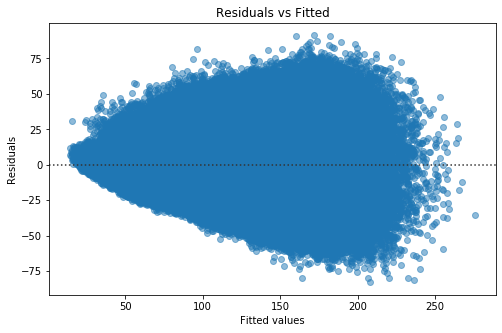

In [16]:
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(5)
plot_lm_1.set_figwidth(8)

model_fitted_y = lm.fittedvalues

plot_lm_1.axes[0] = sns.residplot(model_fitted_y, 'salary', data = data.train_df, 
                          scatter_kws={'alpha': 0.5})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

## Detecting Linearity, Normal Distribution of Residuals, & Zero Mean

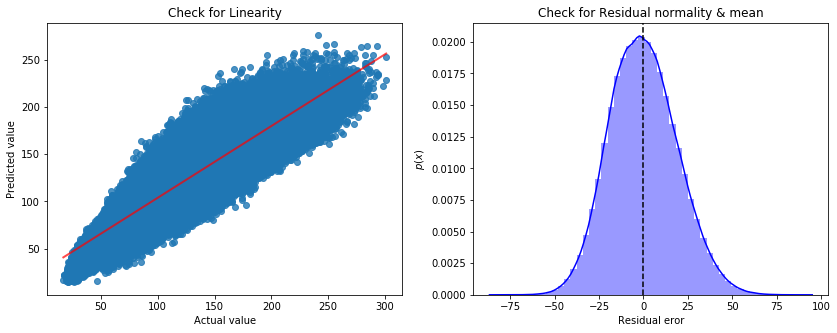

In [17]:
import seaborn as sns

# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
#sns.scatterplot(y_test,y_pred_ols,ax=ax,color=['r','g'])
# use the function regplot to make a scatterplot
sns.regplot(x=data.train_df.salary, y=model_fitted_y, line_kws={"color":"r","alpha":0.7,"lw":2})
plt.title('Check for Linearity')
plt.xlabel('Actual value')
plt.ylabel('Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((data.train_df.salary - model_fitted_y),ax=ax,color='b')
plt.axvline((data.train_df.salary - model_fitted_y).mean(),color='k',linestyle='--')
plt.title('Check for Residual normality & mean')
plt.xlabel('Residual eror')
plt.ylabel('$p(x)$');

## Checking the normality of the residuals

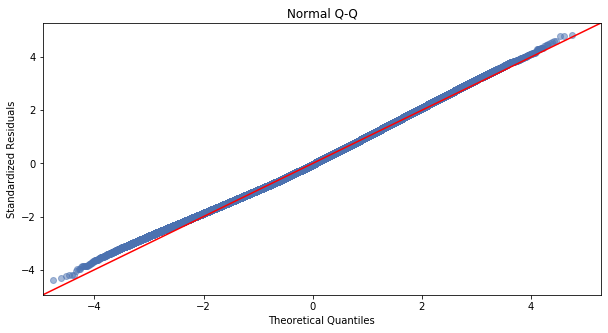

In [18]:
from statsmodels.graphics.gofplots import ProbPlot

# fitted values (need a constant term for intercept)
model_fitted_y = lm.fittedvalues

# model residuals
model_residuals = lm.resid

# normalized residuals
model_norm_residuals = lm.get_influence().resid_studentized_internal
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

plot_lm_2.set_figheight(5)
plot_lm_2.set_figwidth(10)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

## Modelling

In [20]:
X = data.train_df.drop(["salary","index","jobId"],axis=1)
Y = data.train_df.salary

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [22]:
lr = LinearRegression()

# Fit the model
lr.fit(X_train, y_train)

# Make predictions
predictions = lr.predict(X_test)

In [23]:
np.sqrt(mean_squared_error(y_test, predictions))

18.93297447448977